### Model Training

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unrar x '/content/drive/MyDrive/EarVN1.0 dataset.rar'

Streaming output truncated to the last 5000 lines.
Extracting  EarVN1.0 dataset/Images/134.Minh_Tr/134 (96).jpg              80%  OK 
Extracting  EarVN1.0 dataset/Images/134.Minh_Tr/134 (97).jpg              80%  OK 
Extracting  EarVN1.0 dataset/Images/134.Minh_Tr/134 (98).jpg              80%  OK 
Extracting  EarVN1.0 dataset/Images/134.Minh_Tr/134 (99).jpg              80%  OK 
Creating    EarVN1.0 dataset/Images/135.Minh_T                        OK
Extracting  EarVN1.0 dataset/Images/135.Minh_T/135 (1).jpg                80%  OK 
Extracting  EarVN1.0 dataset/Images/135.Minh_T/135 (10).jpg               80%  OK 
Extracting  EarVN1.0 dataset/Images/135.Minh_T/135 (100).jpg              80%  OK 
Extracting  EarVN1.0 dataset/Images/135.Minh_T/135 (101).jpg              80%  OK 
Extracting  EarVN1.0 dataset/Images/135.Minh_T/135 (102).jpg              80%  OK 
Extracting  EarVN1.0 dataset/Images/135.Minh_T/1

In [3]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [4]:
DATA_DIR = '/content/EarVN1.0 dataset/Images/'
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64

In [5]:
train_val_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.15,
  label_mode='int',
  subset="training",
  seed=999,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 28412 files belonging to 164 classes.
Using 24151 files for training.


In [6]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.15,
  label_mode='int',
  subset="validation",
  seed=999,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 28412 files belonging to 164 classes.
Using 4261 files for validation.


In [7]:
train_val_batches = tf.data.experimental.cardinality(train_val_ds)
train_val_batches

<tf.Tensor: shape=(), dtype=int64, numpy=378>

In [8]:
TOTAL_TRAIN_VAL = len(train_val_ds)
print(TOTAL_TRAIN_VAL)
train_ds = train_val_ds.take(int(8 * train_val_batches / 10))
val_ds = train_val_ds.skip(int(8 * train_val_batches / 10))
print(len(train_ds))
print(len(val_ds))

378
302
76


In [9]:
train_ds

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [11]:
base_model_VGG19 = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

80134624/80134624 [==============================] - 0s 0us/step


In [13]:
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D

model = tf.keras.Sequential()
model.add(base_model_VGG19)
model.add(GlobalMaxPooling2D())
model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(164, activation = 'softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_max_pooling2d (Glob  (None, 512)               0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 4096)              2101248   
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 164)               671908    
                                                                 
Total params: 22797540 (86.97 MB)
Trainable params: 22797540 (86.97 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [15]:
from tensorflow.keras import optimizers, losses
model.compile(optimizer=optimizers.Adam(learning_rate=3e-4), loss='sparse_categorical_crossentropy', metrics='accuracy')

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint(
    filepath='./best_vgg19_model_epoch={epoch:02d}_acc={val_accuracy:0.4f}.h5',
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    save_freq='epoch'
)

In [19]:
from keras.models import load_model

model_path = '/content/drive/MyDrive/best_vgg19_model_epoch=35_acc=0.2780.h5'

model = load_model(model_path)

In [20]:
results = model.fit(train_ds, validation_data=val_ds, epochs=15, batch_size=64, callbacks=[mc])

Epoch 1/15
302/302 [==============================] - ETA: 0s - loss: 0.3574 - accuracy: 0.8900
Epoch 1: val_accuracy improved from -inf to 0.25835, saving model to ./best_vgg19_model_epoch=01_acc=0.2583.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


302/302 [==============================] - 352s 1s/step - loss: 0.3574 - accuracy: 0.8900 - val_loss: 6.0271 - val_accuracy: 0.2583
Epoch 2/15
302/302 [==============================] - ETA: 0s - loss: 0.3480 - accuracy: 0.8921
Epoch 2: val_accuracy improved from 0.25835 to 0.27244, saving model to ./best_vgg19_model_epoch=02_acc=0.2724.h5
302/302 [==============================] - 321s 1s/step - loss: 0.3480 - accuracy: 0.8921 - val_loss: 6.1100 - val_accuracy: 0.2724
Epoch 3/15
302/302 [==============================] - ETA: 0s - loss: 0.3313 - accuracy: 0.8985
Epoch 3: val_accuracy did not improve from 0.27244
302/302 [==============================] - 315s 1s/step - loss: 0.3313 - accuracy: 0.8985 - val_loss: 6.0272 - val_accuracy: 0.2697
Epoch 4/15
302/302 [==============================] - ETA: 0s - loss: 0.3337 - accuracy: 0.8991
Epoch 4: val_accuracy improved from 0.27244 to 0.27721, saving model to ./best_vgg19_model_epoch=04_acc=0.2772.h5
302/302 [============================

In [21]:
predictions = []
y_true = []
for img, labels in test_ds:
    predictions.extend(model.predict_on_batch(img))
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

In [22]:
y_pred = np.argmax(predictions, axis=1)

In [23]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.24      0.26      0.25        50
           1       0.21      0.41      0.27        39
           2       0.09      0.21      0.13        24
           3       0.10      0.06      0.08        31
           4       0.31      0.26      0.29        34
           5       0.11      0.11      0.11        35
           6       0.24      0.35      0.29        23
           7       0.15      0.19      0.17        26
           8       0.09      0.09      0.09        35
           9       0.30      0.25      0.27        28
          10       0.25      0.35      0.29        23
          11       0.24      0.24      0.24        29
          12       0.22      0.21      0.21        24
          13       0.25      0.35      0.29        17
          14       0.45      0.41      0.43        34
          15       0.41      0.25      0.31        28
          16       0.12      0.13      0.13        23
          17       0.15    

In [24]:
history = results.history

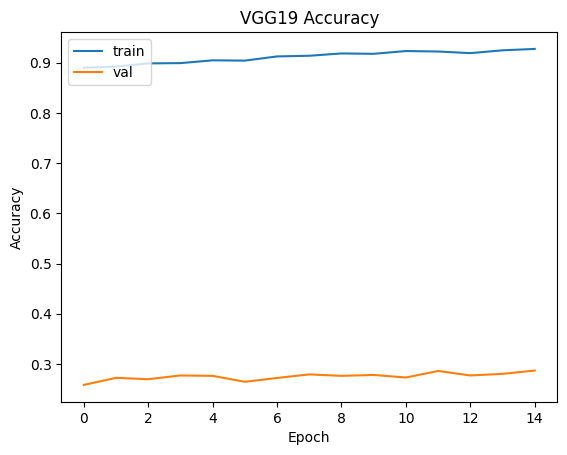

In [25]:
from matplotlib import pyplot as plt

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('VGG19 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

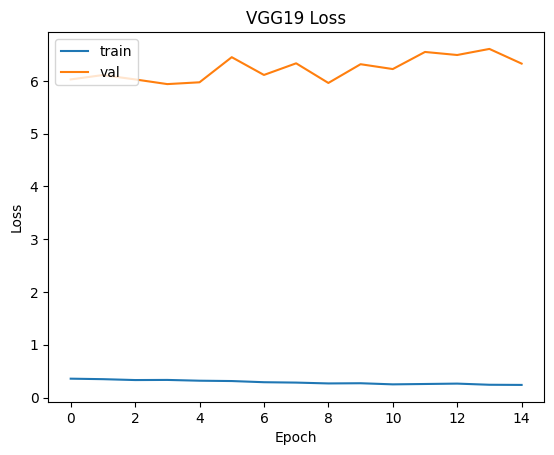

In [26]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('VGG19 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()